## SVM (classification) sur IRIS
---

### Commencant par l'importation des bibliothèques nécessaires : 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
)


In [3]:
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True


### 1. Chargement des données (IRIS)

In [4]:
iris = load_iris(as_frame=True)
df = iris.frame  
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### 2.Exploration rapide (dimensions, valeurs manquantes, classes)

*** 1- Dimensions ***

In [5]:
print("Shape:", df.shape)  

Shape: (150, 5)


*** 2- Valeurs manquantes ***

In [6]:
df.isna().sum()


sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

*** 3- Répartition des classes ***

In [7]:
df["target"].value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

*** Afficher les noms des classes : ***

In [8]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


### 3. Préparation X / y

In [9]:
X = df.drop(columns=["target"])
y = df["target"]

Petit aperçu des features :

In [10]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### 4- Répartition Train / Test (seed fixe + stratify)

*** On garde un test set pour l’évaluation finale (jamais utilisé dans la recherche d’hyperparamètres). ***

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(120, 4) (30, 4)


### 5- Baseline (modèle simple)

*** Baseline 1 : DummyClassifier (majoritaire) ***

In [12]:
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

print("Baseline accuracy:", accuracy_score(y_test, y_pred_base))
print("Baseline F1 macro:", f1_score(y_test, y_pred_base, average="macro"))
print(classification_report(y_test, y_pred_base, target_names=iris.target_names))

Baseline accuracy: 0.3333333333333333
Baseline F1 macro: 0.16666666666666666
              precision    recall  f1-score   support

      setosa       0.33      1.00      0.50        10
  versicolor       0.00      0.00      0.00        10
   virginica       0.00      0.00      0.00        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_c

### 6- Modèle SVM “propre” avec Pipeline (standardisation + SVC)

In [13]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])
pipe

,steps,"[('scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


Entraînement simple (sans tuning) : 

In [14]:
pipe.fit(X_train, y_train)
y_pred_default = pipe.predict(X_test)

print("SVC default accuracy:", accuracy_score(y_test, y_pred_default))
print("SVC default F1 macro:", f1_score(y_test, y_pred_default, average="macro"))
print(classification_report(y_test, y_pred_default, target_names=iris.target_names))

SVC default accuracy: 0.9666666666666667
SVC default F1 macro: 0.9665831244778612
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Matrice de confusion : 

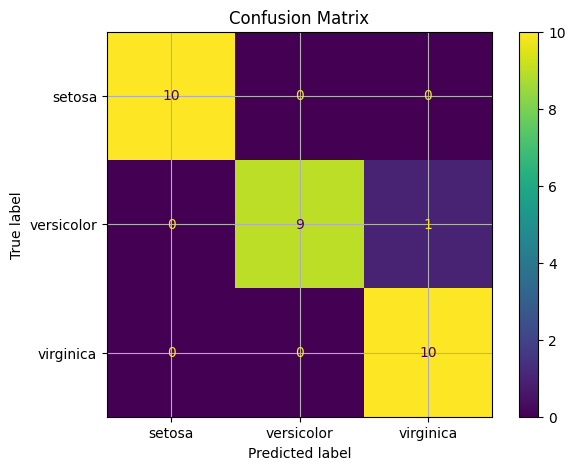

In [15]:
cm = confusion_matrix(y_test, y_pred_default)
disp = ConfusionMatrixDisplay(cm, display_labels=iris.target_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

## 7) Recherche d’hyperparamètres (grille courte ou aléatoire)

Objectif : améliorer le SVM en testant plusieurs valeurs de **C**, **gamma** et **kernel**.

- **C** : force de régularisation (plus grand = modèle plus “strict” sur les données).
- **gamma** (pour `rbf`) : influence de chaque point (trop grand → sur-apprentissage).
- **kernel** : type de frontière (linéaire ou non linéaire `rbf`).

On utilise une **grille courte** (rapide) + validation croisée interne sur *train*.


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe_tune = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=42))
])

param_grid = [
    {
        "svc__kernel": ["rbf"],
        "svc__C": [0.1, 1, 10, 100],
        "svc__gamma": ["scale", 0.01, 0.1, 1.0],
    },
    {
        "svc__kernel": ["linear"],
        "svc__C": [0.1, 1, 10, 100],
    },
]

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_tune,
    param_grid=param_grid,
    scoring="f1_macro",      
    cv=cv_inner,
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid.best_params_)
print("Meilleur score CV (F1 macro) :", round(grid.best_score_, 4))

best_model = grid.best_estimator_
best_model


Meilleurs hyperparamètres : {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Meilleur score CV (F1 macro) : 0.9749


,steps,"[('scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1
,kernel,'rbf'
,degree,3
,gamma,0.1


### Évaluation du meilleur modèle sur le jeu de test
On compare les performances du **best_model** (tuned) sur `X_test`.


Accuracy (test) : 0.9667
F1 macro  (test) : 0.9666

Classification report :

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



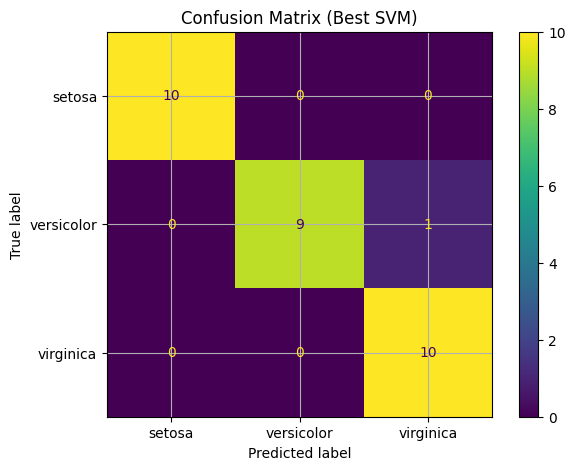

In [17]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_best = best_model.predict(X_test)

print("Accuracy (test) :", round(accuracy_score(y_test, y_pred_best), 4))
print("F1 macro  (test) :", round(f1_score(y_test, y_pred_best, average="macro"), 4))
print("\nClassification report :\n")
print(classification_report(y_test, y_pred_best, target_names=iris.target_names))

cm_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=iris.target_names)
disp.plot()
plt.title("Confusion Matrix (Best SVM)")
plt.show()


## 8) Évaluation avec validation croisée (k=5 ou 10)

Ici on évalue la **robustesse** du modèle avec une validation croisée sur **tout le dataset**.
- k=5 : plus rapide
- k=10 : souvent un peu plus stable


In [18]:
from sklearn.model_selection import cross_val_score

cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores_f1 = cross_val_score(best_model, X, y, cv=cv_outer, scoring="f1_macro", n_jobs=-1)
scores_acc = cross_val_score(best_model, X, y, cv=cv_outer, scoring="accuracy", n_jobs=-1)

print("CV (k=10) - F1 macro : moyenne =", round(scores_f1.mean(), 4), " / écart-type =", round(scores_f1.std(), 4))
print("CV (k=10) - Accuracy : moyenne =", round(scores_acc.mean(), 4), " / écart-type =", round(scores_acc.std(), 4))


CV (k=10) - F1 macro : moyenne = 0.9659  / écart-type = 0.0461
CV (k=10) - Accuracy : moyenne = 0.9667  / écart-type = 0.0447


## 9) Interprétation (importances, erreurs typiques, limites)

### a) Importance des variables (Permutation Importance)
Pour un SVM (surtout `rbf`), il n’y a pas de “feature_importances_” direct.
On peut utiliser **Permutation Importance** : on mélange une colonne, et on regarde combien le score baisse.


In [ ]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model, X_test, y_test,
    scoring="f1_macro",
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

importances = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

importances


,feature,importance_mean,importance_std
3,petal width (cm),0.296897,0.073824
2,petal length (cm),0.242898,0.076197
1,sepal width (cm),0.055154,0.038735
0,sepal length (cm),-0.007825,0.023868


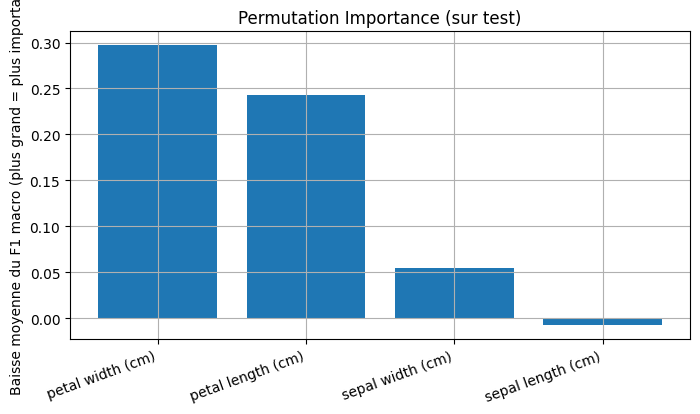

In [20]:
# Visualisation
plt.figure(figsize=(8, 4))
plt.bar(importances["feature"], importances["importance_mean"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Baisse moyenne du F1 macro (plus grand = plus important)")
plt.title("Permutation Importance (sur test)")
plt.show()


### b) Erreurs typiques (exemples mal classés)
On affiche quelques lignes du test où le modèle se trompe, avec les probabilités.


In [21]:
proba_test = best_model.predict_proba(X_test)
proba_df = pd.DataFrame(proba_test, columns=iris.target_names)

errors = X_test.copy()
errors = errors.reset_index(drop=True)
errors["y_true"] = y_test.reset_index(drop=True).map(lambda i: iris.target_names[i])
errors["y_pred"] = pd.Series(y_pred_best).map(lambda i: iris.target_names[i])
errors = pd.concat([errors, proba_df.reset_index(drop=True)], axis=1)

misclassified = errors[errors["y_true"] != errors["y_pred"]]
misclassified.head(10)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_true,y_pred,setosa,versicolor,virginica
25,6.7,3.0,5.0,1.7,versicolor,virginica,0.01116,0.384267,0.604573


### c) Limites (à expliquer dans ton rapport)

- **Dataset petit** (150 lignes) : résultats très bons mais pas forcément généralisables à d’autres fleurs / données réelles.
- **SVM + probabilités** : `probability=True` fait une calibration (Platt scaling) → plus lent.
- **Interprétation** : pour `rbf`, le modèle est non linéaire → l’interprétation est moins directe (Permutation Importance aide).
- **Choix d’hyperparamètres** : une grille trop large peut sur-optimiser sur la CV ; on garde une grille courte.


## 10) Packaging Colab (exécutable, commentaires, seed, version libs)

Pour rendre ton notebook “propre” sur Colab :
1. **Mettre un seed** (reproductibilité)
2. **Afficher les versions** des libs
3. Vérifier que **Runtime > Run all** marche sans erreurs


In [ ]:
import random, numpy as np
random.seed(42)
np.random.seed(42)

import sys, platform
import sklearn, pandas, matplotlib

print("Python       :", sys.version.split()[0])
print("Platform     :", platform.platform())
print("NumPy        :", np.__version__)
print("Pandas       :", pandas.__version__)
print("Matplotlib   :", matplotlib.__version__)
print("Scikit-learn :", sklearn.__version__)


Python       : 3.13.9
Platform     : Windows-11-10.0.26200-SP0
NumPy        : 2.3.2
Pandas       : 2.3.3
Matplotlib   : 3.10.7
Scikit-learn : 1.7.2
